# Optimising model complexity with gradient information

This notebook demonstrates how the difference in performance between neural networks trained with and without gradients can be used to determine an upper-bound on model complexity. This example uses the 2-dimensional and 4-dimensional surrogate modeling problems discussed in Chapter 3 and an additional 8-dimensional toy problem, discussed in Chapter 4.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from collections import defaultdict

In [192]:
# Load in experimental results
foldernames = ['2D', '4D', '8D']
all_results = defaultdict(dict)
base = 'rp-working/Experimental results'
for ts_folder in foldernames:
    files = listdir(base+'/'+ts_folder)
    for f in files:
        if not f.startswith('.'):
            all_results[ts_folder][f] = {}
            for r in listdir(f'{base}/{ts_folder}/{f}'):
                if 'grad_test_corr' in r:
                    all_results[ts_folder][f]['grad_test_corr'] = pd.read_csv(f'{base}/{ts_folder}/{f}/{r}', index_col=0)
                elif 'grad_train_corr' in r:
                    all_results[ts_folder][f]['grad_train_corr'] = pd.read_csv(f'{base}/{ts_folder}/{f}/{r}', index_col=0)
                elif 'grad_test_rmse' in r:
                    all_results[ts_folder][f]['grad_test_rmse'] = pd.read_csv(f'{base}/{ts_folder}/{f}/{r}', index_col=0)
                elif 'grad_train_rmse' in r:
                    all_results[ts_folder][f]['grad_train_rmse'] = pd.read_csv(f'{base}/{ts_folder}/{f}/{r}', index_col=0)
                elif 'std_train_corr' in r:
                    all_results[ts_folder][f]['std_train_corr'] = pd.read_csv(f'{base}/{ts_folder}/{f}/{r}', index_col=0)
                elif 'std_test_rmse' in r:
                    all_results[ts_folder][f]['std_test_rmse'] = pd.read_csv(f'{base}/{ts_folder}/{f}/{r}', index_col=0)
                elif 'std_train_rmse' in r:
                    all_results[ts_folder][f]['std_train_rmse'] = pd.read_csv(f'{base}/{ts_folder}/{f}/{r}', index_col=0)
                elif 'std_test_corr' in r:
                    all_results[ts_folder][f]['std_test_corr'] = pd.read_csv(f'{base}/{ts_folder}/{f}/{r}', index_col=0)


In [194]:
# Function to find UB compelxity

def find_UB_idx(grad_corr, std_corr, grad_rmse, std_rmse):
    """ Function finds the model complexity at which the benefit of gradient information is eliminated (or minimised
    if it persists)."""
    
    # Check if gradient outperformance is eliminated
#     if sum(grad_corr['mean'] - grad_corr['mean'] < 0) != 0 or sum(std_rmse['mean'] - grad_rmse['mean'] < 0) != 0:
#         corr_diff = grad_corr['mean'] - std_corr['mean']
#         rmse_diff = std_rmse['mean'] - grad_rmse['mean']
#         corr_idx = np.where(corr_diff < 0)[0][0]
#         rmse_idx = np.where(rmse_diff < 0)[0][0]
#         corr_idx = grad_corr.index[corr_idx]
#         rmse_idx = grad_corr.index[rmse_idx]
        
#     else:
    # Else use minimum difference
    corr_diff = abs(grad_corr['mean'] - std_corr['mean'])
    rmse_diff = abs(std_rmse['mean'] - grad_rmse['mean'])
    corr_idx = np.where(corr_diff == corr_diff.min())[0][0]
    rmse_idx = np.where(rmse_diff == rmse_diff.min())[0][0]
    corr_idx = grad_corr.index[corr_idx]
    rmse_idx = grad_corr.index[rmse_idx]
        
        
    return max(corr_idx, rmse_idx)

## 2D problem

nTrain50 - Optimal: 36, UB: 40
nTrain100 - Optimal: 40, UB: 52
nTrain300 - Optimal: 28, UB: 52
nTrain500 - Optimal: 24, UB: 32
nTrain700 - Optimal: 20, UB: 20


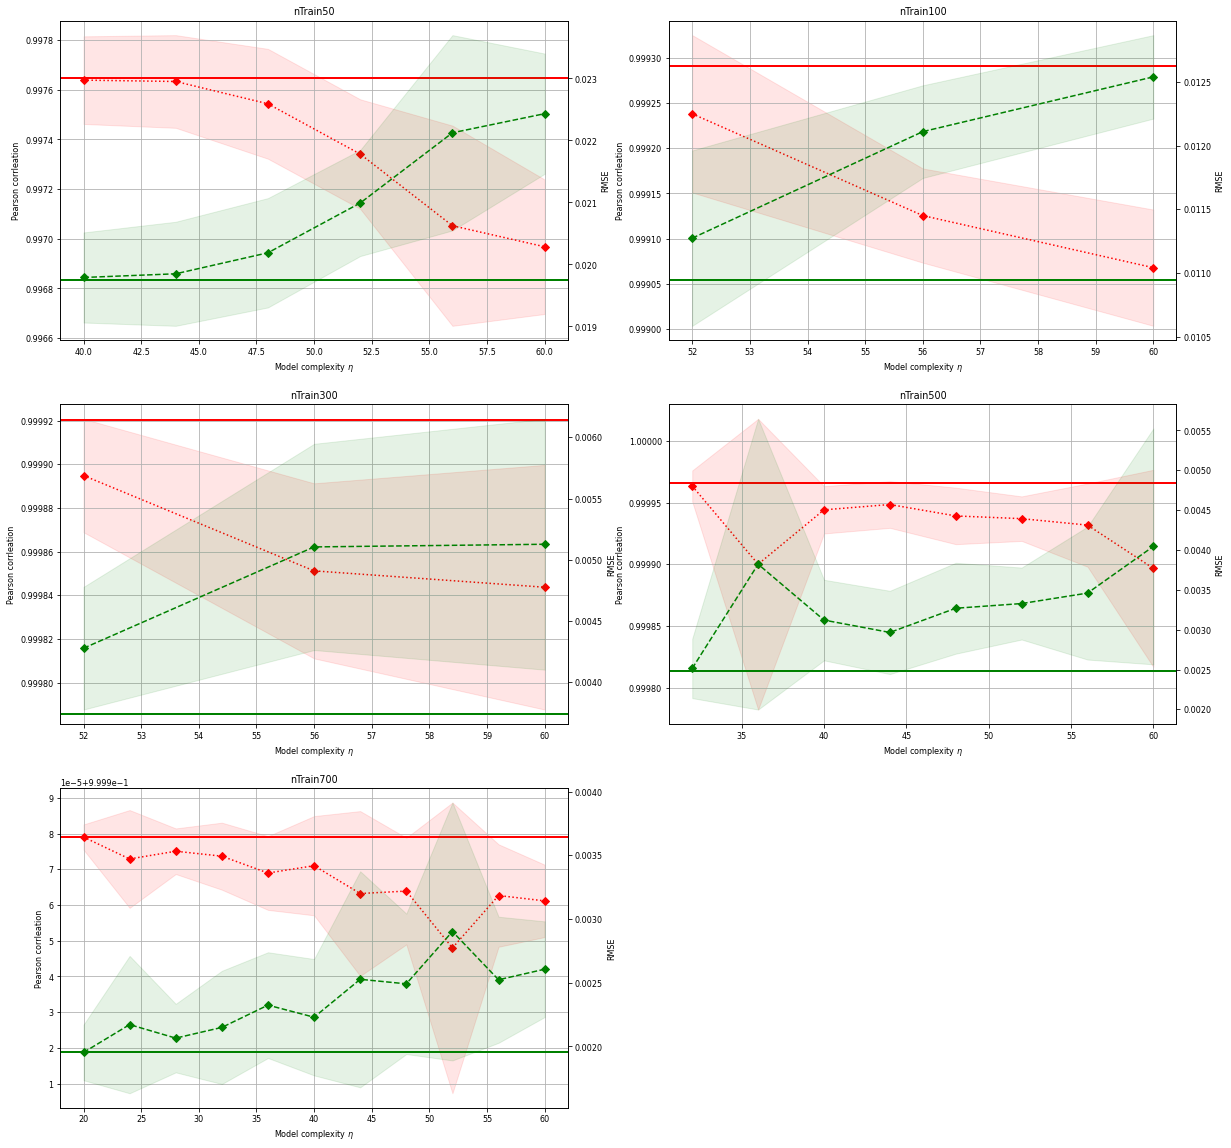

In [186]:
# Formatting
fig=plt.figure(figsize=(20,20), facecolor='white')
plt.rcParams.update({'font.size': 8})
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)

lw = 2

complexity_flag = '2D'

interval = 4 # Step-size for model complexity
max_complexity = 60 # Max complexity experimented with

sample_sizes = ['nTrain50', 'nTrain100', 'nTrain300','nTrain500','nTrain700']
#sample_sizes = sorted(samples_sizes, key=len)

grad_corrs = []
grad_rmses = []
std_corrs = []
std_rmses = []

[std_corrs.append(all_results[complexity_flag][ss]['std_test_corr']) for ss in sample_sizes];
[std_rmses.append(all_results[complexity_flag][ss]['std_test_rmse']) for ss in sample_sizes];
[grad_corrs.append(all_results[complexity_flag][ss]['grad_test_corr']) for ss in sample_sizes];
[grad_rmses.append(all_results[complexity_flag][ss]['grad_test_rmse']) for ss in sample_sizes];

# markers = ['s', 'D', 'v', 'p', '*']
# colours = ['#E0A500', '#E22712', '#0795ED', '#5FAB80', '#842DB4']

axes = [ax1, ax2, ax3, ax4, ax5]

for grad_corr, std_corr, grad_rmse, std_rmse, ax, title in zip(grad_corrs, std_corrs, grad_rmses, std_rmses, axes, sample_sizes):
    idx = find_UB_idx(grad_corr, std_corr, grad_rmse, std_rmse)
    std_dev_corr = std_corr['std'].loc[idx:]
    std_dev_rmse = std_rmse['std'].loc[idx:]
    ax.plot(std_corr['mean'].loc[idx:], c='r', marker='D', linestyle=':')
    ax.fill_between(np.arange(idx, max_complexity+interval, interval), std_corr['mean'].loc[idx:] + std_dev_corr, std_corr['mean'].loc[idx:] - std_dev_corr, color='r', alpha=0.1)
    
    # Add correlation of optimal model
    ax.axhline(std_corr['mean'].max(), linestyle='-', c='r', lw=lw)
    
    ax.set_ylabel('Pearson corrleation')
    axtwin = ax.twinx()
    axtwin.plot(std_rmse['mean'].loc[idx:], c='g', marker='D', linestyle='--')
    axtwin.fill_between(np.arange(idx, max_complexity+interval, interval), std_rmse['mean'].loc[idx:] + std_dev_rmse, std_rmse['mean'].loc[idx:] - std_dev_rmse, color='g', alpha=0.1)
    
    # Add RMSE of optimal model
    axtwin.axhline(std_rmse['mean'].min(), linestyle='-', c='g', lw=lw)
    axtwin.set_ylabel('RMSE')
    ax.set_title(title)
    ax.set_xlabel(r'Model complexity $\eta$')
    ax.grid()
    # Check results
    if sum(std_corr['mean'].max() == std_corr['mean'].loc[idx+interval:]) == 1:
        print(f'Optimal correlation above UB for {title}')
    if sum(std_rmse['mean'].min() == std_rmse['mean'].loc[idx+interval:]) == 1:
        print(f'Optimal RMSE above UB for {title}')
        
    # Print optimal and UB
    print(f"{title} - Optimal: {std_rmse.index[np.where(std_rmse['mean'].min() == std_rmse['mean'])[0][0]]}, UB: {idx}")

## 4D problem

nTrain100 - Optimal: 10, UB: 46
Optimal correlation above UB for nTrain300
Optimal RMSE above UB for nTrain300
nTrain300 - Optimal: 6, UB: 2
nTrain500 - Optimal: 6, UB: 6
Optimal RMSE above UB for nTrain700
nTrain700 - Optimal: 6, UB: 2


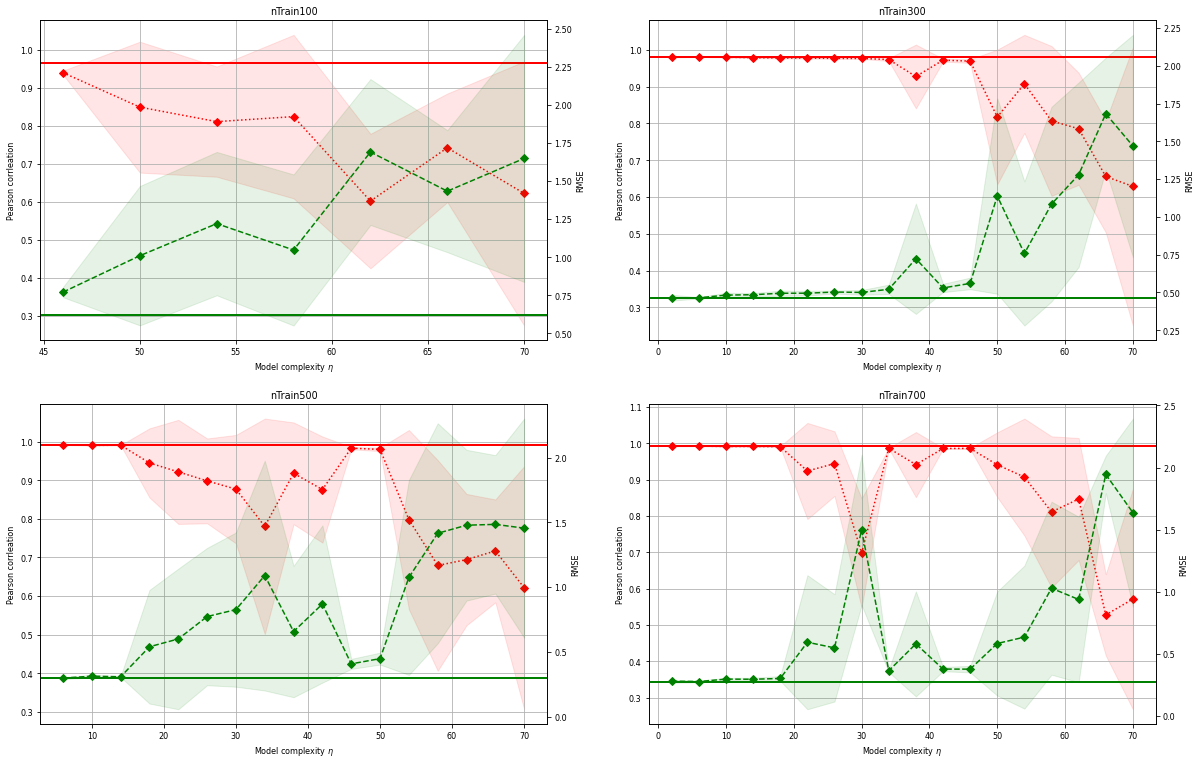

In [196]:
# Formatting
fig=plt.figure(figsize=(20,20), facecolor='white')
plt.rcParams.update({'font.size': 8})
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)

lw = 2

complexity_flag = '4D'

interval = 4 # Step-size for model complexity
max_complexity = 70 # Max complexity experimented with

sample_sizes = ['nTrain100', 'nTrain300','nTrain500','nTrain700']
#sample_sizes = sorted(samples_sizes, key=len)

grad_corrs = []
grad_rmses = []
std_corrs = []
std_rmses = []

[std_corrs.append(all_results[complexity_flag][ss]['std_test_corr']) for ss in sample_sizes];
[std_rmses.append(all_results[complexity_flag][ss]['std_test_rmse']) for ss in sample_sizes];
[grad_corrs.append(all_results[complexity_flag][ss]['grad_test_corr']) for ss in sample_sizes];
[grad_rmses.append(all_results[complexity_flag][ss]['grad_test_rmse']) for ss in sample_sizes];

# markers = ['s', 'D', 'v', 'p', '*']
# colours = ['#E0A500', '#E22712', '#0795ED', '#5FAB80', '#842DB4']

axes = [ax1, ax2, ax3, ax4, ax5]

for grad_corr, std_corr, grad_rmse, std_rmse, ax, title in zip(grad_corrs, std_corrs, grad_rmses, std_rmses, axes, sample_sizes):
    idx = find_UB_idx(grad_corr, std_corr, grad_rmse, std_rmse)
    std_dev_corr = std_corr['std'].loc[idx:]
    std_dev_rmse = std_rmse['std'].loc[idx:]
    ax.plot(std_corr['mean'].loc[idx:], c='r', marker='D', linestyle=':')
    ax.fill_between(np.arange(idx, max_complexity+interval, interval), std_corr['mean'].loc[idx:] + std_dev_corr, std_corr['mean'].loc[idx:] - std_dev_corr, color='r', alpha=0.1)
    
    # Add correlation of optimal model
    ax.axhline(std_corr['mean'].max(), linestyle='-', c='r', lw=lw)
    
    ax.set_ylabel('Pearson corrleation')
    axtwin = ax.twinx()
    axtwin.plot(std_rmse['mean'].loc[idx:], c='g', marker='D', linestyle='--')
    axtwin.fill_between(np.arange(idx, max_complexity+interval, interval), std_rmse['mean'].loc[idx:] + std_dev_rmse, std_rmse['mean'].loc[idx:] - std_dev_rmse, color='g', alpha=0.1)
    
    # Add RMSE of optimal model
    axtwin.axhline(std_rmse['mean'].min(), linestyle='-', c='g', lw=lw)
    axtwin.set_ylabel('RMSE')
    ax.set_title(title)
    ax.set_xlabel(r'Model complexity $\eta$')
    ax.grid()
    # Check results
    if sum(std_corr['mean'].max() == std_corr['mean'].loc[idx+interval:]) == 1:
        print(f'Optimal correlation above UB for {title}')
    if sum(std_rmse['mean'].min() == std_rmse['mean'].loc[idx+interval:]) == 1:
        print(f'Optimal RMSE above UB for {title}')
        
    # Print optimal and UB
    print(f"{title} - Optimal: {std_rmse.index[np.where(std_rmse['mean'].min() == std_rmse['mean'])[0][0]]}, UB: {idx}")

## 8D problem

nTrain2500 - Optimal: 30, UB: 30
nTrain5000 - Optimal: 20, UB: 20
nTrain7500 - Optimal: 30, UB: 30
nTrain10000 - Optimal: 20, UB: 20


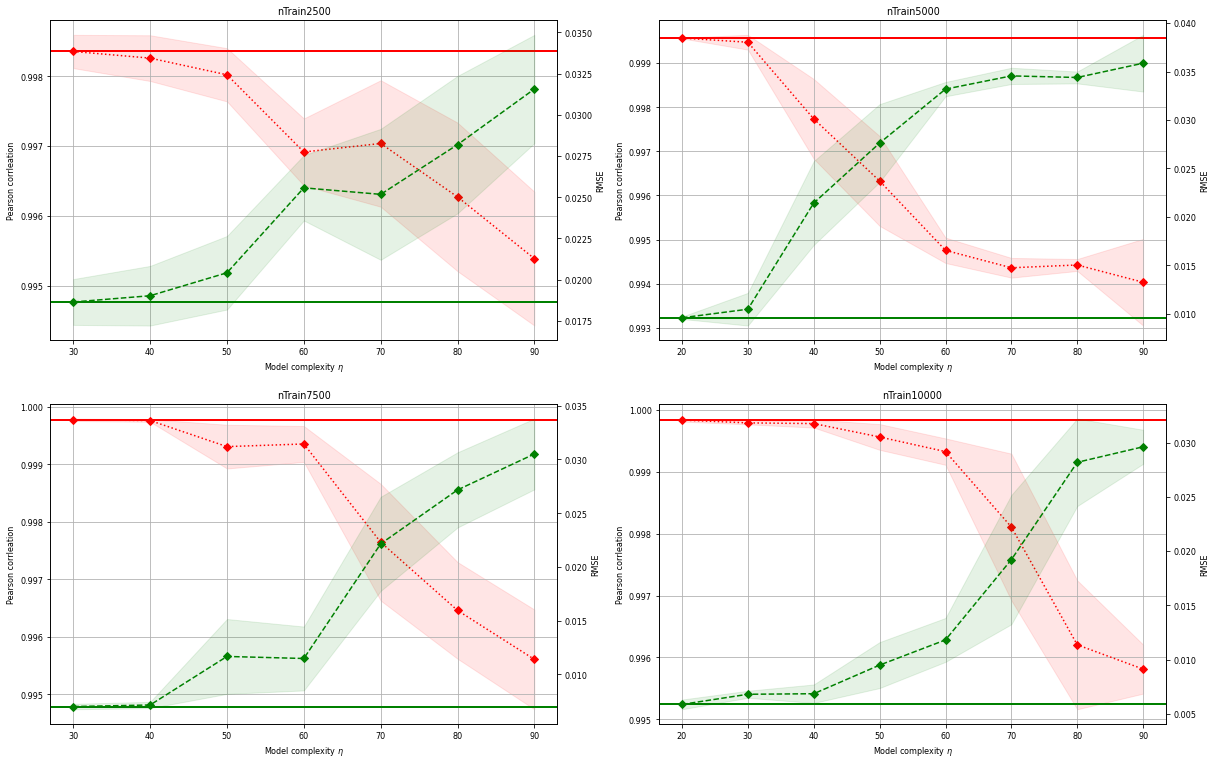

In [195]:
# Formatting
fig=plt.figure(figsize=(20,20), facecolor='white')
plt.rcParams.update({'font.size': 8})
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)

lw = 2

complexity_flag = '8D'

interval = 10 # Step-size for model complexity
max_complexity = 90 # Max complexity experimented with

sample_sizes = ['nTrain2500', 'nTrain5000','nTrain7500', 'nTrain10000']
#sample_sizes = sorted(samples_sizes, key=len)

grad_corrs = []
grad_rmses = []
std_corrs = []
std_rmses = []

[std_corrs.append(all_results[complexity_flag][ss]['std_test_corr']) for ss in sample_sizes];
[std_rmses.append(all_results[complexity_flag][ss]['std_test_rmse']) for ss in sample_sizes];
[grad_corrs.append(all_results[complexity_flag][ss]['grad_test_corr']) for ss in sample_sizes];
[grad_rmses.append(all_results[complexity_flag][ss]['grad_test_rmse']) for ss in sample_sizes];

# markers = ['s', 'D', 'v', 'p', '*']
# colours = ['#E0A500', '#E22712', '#0795ED', '#5FAB80', '#842DB4']

axes = [ax1, ax2, ax3, ax4, ax5]

for grad_corr, std_corr, grad_rmse, std_rmse, ax, title in zip(grad_corrs, std_corrs, grad_rmses, std_rmses, axes, sample_sizes):
    idx = find_UB_idx(grad_corr, std_corr, grad_rmse, std_rmse)
    std_dev_corr = std_corr['std'].loc[idx:]
    std_dev_rmse = std_rmse['std'].loc[idx:]
    ax.plot(std_corr['mean'].loc[idx:], c='r', marker='D', linestyle=':')
    ax.fill_between(np.arange(idx, max_complexity+interval, interval), std_corr['mean'].loc[idx:] + std_dev_corr, std_corr['mean'].loc[idx:] - std_dev_corr, color='r', alpha=0.1)
    
    # Add correlation of optimal model
    ax.axhline(std_corr['mean'].max(), linestyle='-', c='r', lw=lw)
    
    ax.set_ylabel('Pearson corrleation')
    axtwin = ax.twinx()
    axtwin.plot(std_rmse['mean'].loc[idx:], c='g', marker='D', linestyle='--')
    axtwin.fill_between(np.arange(idx, max_complexity+interval, interval), std_rmse['mean'].loc[idx:] + std_dev_rmse, std_rmse['mean'].loc[idx:] - std_dev_rmse, color='g', alpha=0.1)
    
    # Add RMSE of optimal model
    axtwin.axhline(std_rmse['mean'].min(), linestyle='-', c='g', lw=lw)
    axtwin.set_ylabel('RMSE')
    ax.set_title(title)
    ax.set_xlabel(r'Model complexity $\eta$')
    ax.grid()
    # Check results
    if sum(std_corr['mean'].max() == std_corr['mean'].loc[idx+interval:]) == 1:
        print(f'Optimal correlation above UB for {title}')
    if sum(std_rmse['mean'].min() == std_rmse['mean'].loc[idx+interval:]) == 1:
        print(f'Optimal RMSE above UB for {title}')
        
    # Print optimal and UB
    print(f"{title} - Optimal: {std_rmse.index[np.where(std_rmse['mean'].min() == std_rmse['mean'])[0][0]]}, UB: {idx}")